# Step 1. 資料前處理

## Step 1-1. 從Tarflow下載資料
+ 資料來源：PTT - 股票版
+ 資料時間範圍：2023/03/31 - 2024/03/31
+ 搜尋關鍵字：台積電
+ 排除關鍵字：
+ 文章總數：2766篇
<!-- + 搜尋關鍵字：台電漲、台電調漲、電費調漲、電費漲、電價調漲、電價漲、漲電 -->


In [1]:
import pandas as pd #pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
import numpy as np #numpy: 為科學運算所提供的套件。提供許多數學公式的實作以及高效率的陣列、矩陣運算。
import matplotlib.pyplot as plt  #matplotlib: 繪圖工具。
import re #re: 正規表達式套件。
import jieba #jieba: 中文斷詞套件。
import jieba.analyse
import math #math: 數學運算工具。
from nltk import ngrams, FreqDist #NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
from collections import Counter, namedtuple #collections: 提供額外的數據類型。

import networkx as nx #networkx: 網絡圖建構、繪製工具。
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer #CountVectorizer, TfidfTransformer: sklearn中計算詞頻與tf-idf的套件。
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from snownlp import SnowNLP #SnowNLP 針對中文設計，可以提取句子的情緒分類
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import time
import datetime
from pprint import pprint
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sentence_transformers import SentenceTransformer, models, util

In [2]:
# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['jf-openhuninn-2.0'] #金萱粉圓體2.0
# plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] 

# 設定文字雲中文字體路徑 金萱粉圓體2.0
FontPath = 'path/to/jf-openhuninn-2.0.ttf' # 設定字型
# FontPath = './SourceHanSansTW-Regular.otf' # 設定字型

plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150


### Step 1-1-1. 匯入資料

In [3]:
#匯入資料
df = pd.read_csv('./Raw_data/PTT_STOCK_TSMC_2303-2403.csv', encoding = 'UTF-8')
df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Stock/M.1680228721.A.45...,[新聞]台積電全年營運承壓超預期 NVIDIA新單縮,2023-03-31 10:11:59,breeze0817,Stock,原文標題：\n\n台積電全年營運承壓超預期 NVIDIA新單縮手、聯發科大砍單\n\n原文連...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""cir78918"", ""...",114.137.187.175,2023-04-01 02:08:56,ptt
1,2,https://www.ptt.cc/bbs/Stock/M.1680229357.A.BB...,[標的]智原3035空,2023-03-31 10:22:33,mayingnine,Stock,-\n1.發標的文未充實內文，\n多空理由不充實\n者，板規1-1-5或4-4處份\n2.進...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""italwayswin""...",217.138.193.206,2023-04-01 02:08:56,ptt
2,3,https://www.ptt.cc/bbs/Stock/M.1680232746.A.1B...,[新聞]談美晶片法案補助！劉德音直言：有些限,2023-03-31 11:19:04,golang,Stock,原文標題：\n\n談美晶片法案補助！劉德音直言：有些限制無法接受\n\n原文連結：\nhtt...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""fujioqq"", ""c...",111.249.84.116,2023-04-01 02:08:56,ptt


### Step 1-1-2. 去除不必要的欄位、新增Sentence

In [4]:
MetaData = df.copy()
MetaData.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)
MetaData['artDate'] =  pd.to_datetime(MetaData['artDate']).dt.to_period('D')

# 去除一些不需要的欄位
MetaData = MetaData.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)
# 只留下中文字
MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
MetaData['sentence'] = MetaData['sentence'].apply(lambda x: re.sub('[口]', '', x))

MetaData.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Stock/M.1680228721.A.45...,[新聞]台積電全年營運承壓超預期 NVIDIA新單縮,2023-03-31,原文標題：\n\n台積電全年營運承壓超預期 NVIDIA新單縮手、聯發科大砍單\n\n原文連...,原文標題台積電全年營運承壓超預期新單縮手聯發科大砍單原文連結發布時間記者署名陳玉娟新竹原文內...
1,2,https://www.ptt.cc/bbs/Stock/M.1680229357.A.BB...,[標的]智原3035空,2023-03-31,-\n1.發標的文未充實內文，\n多空理由不充實\n者，板規1-1-5或4-4處份\n2.進...,發標的文未充實內文多空理由不充實者板規或處份進退場機制若非長期投資請輸入停損價否則依板規處份...
2,3,https://www.ptt.cc/bbs/Stock/M.1680232746.A.1B...,[新聞]談美晶片法案補助！劉德音直言：有些限,2023-03-31,原文標題：\n\n談美晶片法案補助！劉德音直言：有些限制無法接受\n\n原文連結：\nhtt...,原文標題談美晶片法案補助劉德音直言有些限制無法接受原文連結發布時間記者署名原文內容美國晶片法...


### Step 1-1-3. 載入斷詞詞庫

In [5]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [6]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

### Step 1-1-4. 透過jieba產生Word欄位

In [7]:
data = MetaData.copy()

# 斷詞、去除停用字並將word欄位展開
data['word'] = data.sentence.apply(getToken).explode('word')

data.head(3)

Building prefix dict from /Users/aiden/我的雲端硬碟/中山大學資管所/112-2 MIS581 社群媒體分析/Team-8-Project/第8組_HW2/dict/dict.txt.big ...
Dumping model to file cache /var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/jieba.u071a39df812f5f3b749c173887c23e52.cache
Loading model cost 0.555 seconds.
Prefix dict has been built successfully.


,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1680228721.A.45...,[新聞]台積電全年營運承壓超預期 NVIDIA新單縮,2023-03-31,原文標題：\n\n台積電全年營運承壓超預期 NVIDIA新單縮手、聯發科大砍單\n\n原文連...,原文標題台積電全年營運承壓超預期新單縮手聯發科大砍單原文連結發布時間記者署名陳玉娟新竹原文內...,台積電
1,2,https://www.ptt.cc/bbs/Stock/M.1680229357.A.BB...,[標的]智原3035空,2023-03-31,-\n1.發標的文未充實內文，\n多空理由不充實\n者，板規1-1-5或4-4處份\n2.進...,發標的文未充實內文多空理由不充實者板規或處份進退場機制若非長期投資請輸入停損價否則依板規處份...,營運
2,3,https://www.ptt.cc/bbs/Stock/M.1680232746.A.1B...,[新聞]談美晶片法案補助！劉德音直言：有些限,2023-03-31,原文標題：\n\n談美晶片法案補助！劉德音直言：有些限制無法接受\n\n原文連結：\nhtt...,原文標題談美晶片法案補助劉德音直言有些限制無法接受原文連結發布時間記者署名原文內容美國晶片法...,承壓


### Step 1-1-5. 增加StopWords

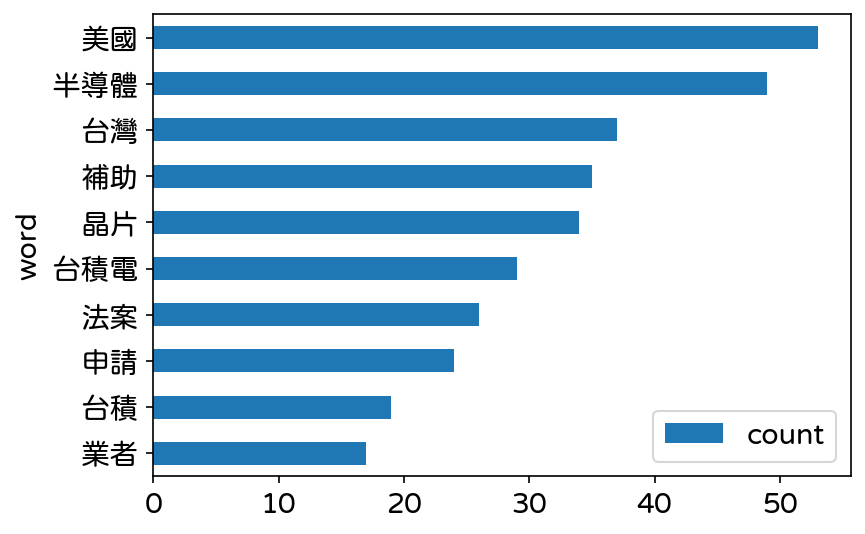

In [8]:
barplot_data = pd.DataFrame(pd.value_counts(data['word'])).reset_index()
barplot_data.columns = ['word','count']
barplot_data = barplot_data.sort_values(by = 'count', ascending = False).reset_index(drop = True)
#barplot_data.to_csv("barplot_data.csv", index=False)
barplot_data.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

In [9]:
#新增停用字
stopWords_manual = ["來源","市場","排行","大神","目前","是不是","也將","紅包","通知","讀版","圖片","以下","需要","連結","記者","署名","發文","發布","時間",
                    "心得","評論","正文","張數","原文","標題","網址","內文","口","張數","家數","年月日","單位","統計","證券","名稱","交易所","代號","謝謝",
                    "分類","標的","報導","格式", "股票名稱", "業者","依板", "版規", "刪除", "內容", "未依", "規處份", "輸入", "文處份", "處份", "股號",
                    "板規", "股名", "類免"]
stopWords.extend(stopWords_manual)

# 重新去除停用字
data['word'] = data.sentence.apply(getToken).explode('word')
data[data['word'].str.contains('排行')]['sentence'].count()

0

In [10]:
#filtered_sentences = data.loc[data['sentence'].str.contains('張券')]
#filtered_sentences

## Step 1-2. 透過DTM計算TF-IDF

In [11]:
TSMC_df = MetaData.copy()
TSMC_df.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Stock/M.1680228721.A.45...,[新聞]台積電全年營運承壓超預期 NVIDIA新單縮,2023-03-31,原文標題：\n\n台積電全年營運承壓超預期 NVIDIA新單縮手、聯發科大砍單\n\n原文連...,原文標題台積電全年營運承壓超預期新單縮手聯發科大砍單原文連結發布時間記者署名陳玉娟新竹原文內...
1,2,https://www.ptt.cc/bbs/Stock/M.1680229357.A.BB...,[標的]智原3035空,2023-03-31,-\n1.發標的文未充實內文，\n多空理由不充實\n者，板規1-1-5或4-4處份\n2.進...,發標的文未充實內文多空理由不充實者板規或處份進退場機制若非長期投資請輸入停損價否則依板規處份...
2,3,https://www.ptt.cc/bbs/Stock/M.1680232746.A.1B...,[新聞]談美晶片法案補助！劉德音直言：有些限,2023-03-31,原文標題：\n\n談美晶片法案補助！劉德音直言：有些限制無法接受\n\n原文連結：\nhtt...,原文標題談美晶片法案補助劉德音直言有些限制無法接受原文連結發布時間記者署名原文內容美國晶片法...


In [12]:
# 保留需要的欄位
TSMC_df = TSMC_df.loc[:,["system_id", "sentence"]]

# 改成使用空格連接斷完的詞
TSMC_df['word'] = TSMC_df.sentence.apply(getToken).map(' '.join)

TSMC_df.head()

,system_id,sentence,word
0,1,原文標題台積電全年營運承壓超預期新單縮手聯發科大砍單原文連結發布時間記者署名陳玉娟新竹原文內...,台積電 營運 承壓 預期 新單 縮手 聯發 科大 砍單 玉娟 新竹 預估 台積 電第季 營收...
1,2,發標的文未充實內文多空理由不充實者板規或處份進退場機制若非長期投資請輸入停損價否則依板規處份...,發標 文未 充實 多空 理由 充實 退場 機制 長期投資 損價 台積電 長期 不停 損多 特...
2,3,原文標題談美晶片法案補助劉德音直言有些限制無法接受原文連結發布時間記者署名原文內容美國晶片法...,談美 晶片 法案 補助 劉德音 直言 接受 美國 晶片 法案 補助 接受 廠商 申請 台積電...
3,4,原文標題美補助晶片要看營業祕密原文連結發布時間記者署名劉忠勇黃淑玲記者尹慧中原文內容美國商務...,補助 晶片 營業 祕密 忠勇 淑玲 尹慧中 美國商務部 公布 晶片 法案 補助 細節 投資 ...
4,5,標的軍工類股例台積電分類多分析正文幾個分析點阿共在演習小英五號要見麥卡錫剛好六號開盤六號阿共...,軍工 類股 例台 積電 分析 幾個 分析 點阿共 演習 小英 五號 麥卡錫 六號 開盤 六號...


In [13]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(TSMC_df["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一一,一丁點,一七,一三五,一三兆,一下子,一下子全部,一中,一九,一九九,...,龍頭股,龍驊,龍鴿,龐大,龐氏,龔明鑫,龔明鑫還,龔銘鑫,龜山,龜速
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2757,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2758,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2759,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2760,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
transformer = TfidfTransformer()  
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())

TFIDF_df

,一一,一丁點,一七,一三五,一三兆,一下子,一下子全部,一中,一九,一九九,...,龍頭股,龍驊,龍鴿,龐大,龐氏,龔明鑫,龔明鑫還,龔銘鑫,龜山,龜速
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Step 1-2-1. 取每一個字詞在所有文件裡的TF-IDF平均值

In [15]:
TSMC_tfidf = TFIDF_df.mean().to_frame().reset_index()
TSMC_tfidf.columns = ["word", "avg"]

TSMC_tfidf.sort_values('avg', ascending = False).head(10)

,word,avg
9194,台積電,0.025609
9053,台灣,0.024408
9183,台積,0.023949
11492,增張,0.023588
11755,外資,0.023321
17256,成交量,0.023035
10819,國泰,0.022126
22801,機制,0.019291
31899,股息,0.019068
18016,投信,0.018524


### Step 1-2-2. 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

In [16]:
toptens = TFIDF_df.copy()
toptens.insert(0, 'doc_id', toptens.index+1)

toptens = toptens.melt(id_vars = "doc_id", var_name = "word", value_name = 'tfidf')
toptens

,doc_id,word,tfidf
0,1,一一,0.0
1,2,一一,0.0
2,3,一一,0.0
3,4,一一,0.0
4,5,一一,0.0
...,...,...,...
119624977,2758,龜速,0.0
119624978,2759,龜速,0.0
119624979,2760,龜速,0.0
119624980,2761,龜速,0.0


In [17]:
(
    # 從每篇文章挑選出tf-idf最大的前十個詞
    toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)
   
    # 計算每個詞被選中的次數
    .groupby(['word'],as_index=False).size()

).sort_values('size', ascending=False).head(10) # 排序看前十名

,word,size
4070,國泰,156
9454,百萬,138
7008,收盤價,137
911,交易,135
4423,外資,134
10835,股息,126
8041,機制,126
7578,晶片,124
10942,自營商,123
509,中信,119


## Step 1-3. 透過N-gram建立斷詞字典

In [18]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]
    
    return seg_list

### Step 1-3-1. Bigram

In [19]:
TSMC_bigram = MetaData.copy()

TSMC_bigram["word"] = TSMC_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
TSMC_bigram = TSMC_bigram.explode('word')

TSMC_bigram.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1680228721.A.45...,[新聞]台積電全年營運承壓超預期 NVIDIA新單縮,2023-03-31,原文標題：\n\n台積電全年營運承壓超預期 NVIDIA新單縮手、聯發科大砍單\n\n原文連...,原文標題台積電全年營運承壓超預期新單縮手聯發科大砍單原文連結發布時間記者署名陳玉娟新竹原文內...,台積電 營運
0,1,https://www.ptt.cc/bbs/Stock/M.1680228721.A.45...,[新聞]台積電全年營運承壓超預期 NVIDIA新單縮,2023-03-31,原文標題：\n\n台積電全年營運承壓超預期 NVIDIA新單縮手、聯發科大砍單\n\n原文連...,原文標題台積電全年營運承壓超預期新單縮手聯發科大砍單原文連結發布時間記者署名陳玉娟新竹原文內...,營運 承壓
0,1,https://www.ptt.cc/bbs/Stock/M.1680228721.A.45...,[新聞]台積電全年營運承壓超預期 NVIDIA新單縮,2023-03-31,原文標題：\n\n台積電全年營運承壓超預期 NVIDIA新單縮手、聯發科大砍單\n\n原文連...,原文標題台積電全年營運承壓超預期新單縮手聯發科大砍單原文連結發布時間記者署名陳玉娟新竹原文內...,承壓 預期


In [20]:
# 計算每個組合出現的次數
TSMC_bigram_count = TSMC_bigram['word'].value_counts().reset_index()

TSMC_bigram_count.sort_values('count', ascending=False).head(10)
#TSMC_bigram_count.to_csv("TSMC_bigram_count.csv", index=False)

,word,count
0,退場 機制,529
1,張券 增張,388
2,信用 交易,350
3,永續 股息,343
4,先進 製程,328
5,國泰 永續,319
6,台灣 科技,284
7,收盤價 漲跌,276
8,百萬 收盤價,275
9,復華 台灣,264


### Step 1-3-1. trigram

In [21]:
TSMC_trigram = MetaData.copy()

TSMC_trigram["word"] = TSMC_trigram.sentence.apply(lambda row: ngram_getToken(row, 3))
TSMC_trigram = TSMC_trigram.explode('word')

TSMC_trigram.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1680228721.A.45...,[新聞]台積電全年營運承壓超預期 NVIDIA新單縮,2023-03-31,原文標題：\n\n台積電全年營運承壓超預期 NVIDIA新單縮手、聯發科大砍單\n\n原文連...,原文標題台積電全年營運承壓超預期新單縮手聯發科大砍單原文連結發布時間記者署名陳玉娟新竹原文內...,台積電 營運 承壓
0,1,https://www.ptt.cc/bbs/Stock/M.1680228721.A.45...,[新聞]台積電全年營運承壓超預期 NVIDIA新單縮,2023-03-31,原文標題：\n\n台積電全年營運承壓超預期 NVIDIA新單縮手、聯發科大砍單\n\n原文連...,原文標題台積電全年營運承壓超預期新單縮手聯發科大砍單原文連結發布時間記者署名陳玉娟新竹原文內...,營運 承壓 預期
0,1,https://www.ptt.cc/bbs/Stock/M.1680228721.A.45...,[新聞]台積電全年營運承壓超預期 NVIDIA新單縮,2023-03-31,原文標題：\n\n台積電全年營運承壓超預期 NVIDIA新單縮手、聯發科大砍單\n\n原文連...,原文標題台積電全年營運承壓超預期新單縮手聯發科大砍單原文連結發布時間記者署名陳玉娟新竹原文內...,承壓 預期 新單


In [22]:
# 計算每個組合出現的次數
TSMC_trigram_count = TSMC_trigram['word'].value_counts().reset_index()

TSMC_trigram_count.sort_values('count', ascending=False).head(10)
#TSMC_trigram_count.to_csv("TSMC_trigram_count.csv", index=False)

,word,count
0,國泰 永續 股息,318
1,百萬 收盤價 漲跌,275
2,復華 台灣 科技,264
3,自營商 投信 外資,238
4,停損 機制 討論,226
5,投資者 停損 機制,226
6,長期 投資者 停損,226
7,台灣 精選 高息,220
8,資增 張券 增張,205
9,台灣 科技 優息,193


## Step 1-4. 透過以上結果，重新斷詞與停用字

In [23]:
# 新增股票相關自定義字典
jieba.load_userdict('./dict/TSMC_lexicon.txt')

stopWords_manual = [""]
stopWords.extend(stopWords_manual)

# 剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken).explode('word')

data2.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1680228721.A.45...,[新聞]台積電全年營運承壓超預期 NVIDIA新單縮,2023-03-31,原文標題：\n\n台積電全年營運承壓超預期 NVIDIA新單縮手、聯發科大砍單\n\n原文連...,原文標題台積電全年營運承壓超預期新單縮手聯發科大砍單原文連結發布時間記者署名陳玉娟新竹原文內...,台積電
1,2,https://www.ptt.cc/bbs/Stock/M.1680229357.A.BB...,[標的]智原3035空,2023-03-31,-\n1.發標的文未充實內文，\n多空理由不充實\n者，板規1-1-5或4-4處份\n2.進...,發標的文未充實內文多空理由不充實者板規或處份進退場機制若非長期投資請輸入停損價否則依板規處份...,營運
2,3,https://www.ptt.cc/bbs/Stock/M.1680232746.A.1B...,[新聞]談美晶片法案補助！劉德音直言：有些限,2023-03-31,原文標題：\n\n談美晶片法案補助！劉德音直言：有些限制無法接受\n\n原文連結：\nhtt...,原文標題談美晶片法案補助劉德音直言有些限制無法接受原文連結發布時間記者署名原文內容美國晶片法...,承壓


## Step 1-5. Bigram視覺化

In [24]:
bigramfdist = MetaData.copy()

bigramfdist["word"] = bigramfdist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramfdist = bigramfdist.explode('word')

bigramfdist.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1680228721.A.45...,[新聞]台積電全年營運承壓超預期 NVIDIA新單縮,2023-03-31,原文標題：\n\n台積電全年營運承壓超預期 NVIDIA新單縮手、聯發科大砍單\n\n原文連...,原文標題台積電全年營運承壓超預期新單縮手聯發科大砍單原文連結發布時間記者署名陳玉娟新竹原文內...,台積電 營運
0,1,https://www.ptt.cc/bbs/Stock/M.1680228721.A.45...,[新聞]台積電全年營運承壓超預期 NVIDIA新單縮,2023-03-31,原文標題：\n\n台積電全年營運承壓超預期 NVIDIA新單縮手、聯發科大砍單\n\n原文連...,原文標題台積電全年營運承壓超預期新單縮手聯發科大砍單原文連結發布時間記者署名陳玉娟新竹原文內...,營運 承壓
0,1,https://www.ptt.cc/bbs/Stock/M.1680228721.A.45...,[新聞]台積電全年營運承壓超預期 NVIDIA新單縮,2023-03-31,原文標題：\n\n台積電全年營運承壓超預期 NVIDIA新單縮手、聯發科大砍單\n\n原文連...,原文標題台積電全年營運承壓超預期新單縮手聯發科大砍單原文連結發布時間記者署名陳玉娟新竹原文內...,承壓 預期


In [25]:
bigramfdist['word'] = bigramfdist['word'].astype(str)

# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist(bigramfdist['word'].apply(lambda x: tuple(x.split(' '))))
bigramfdist.most_common(5)

[(('資增', '券增'), 656),
 (('退場', '機制'), 529),
 (('信用', '交易'), 350),
 (('先進', '製程'), 328),
 (('台灣', '科技'), 284)]

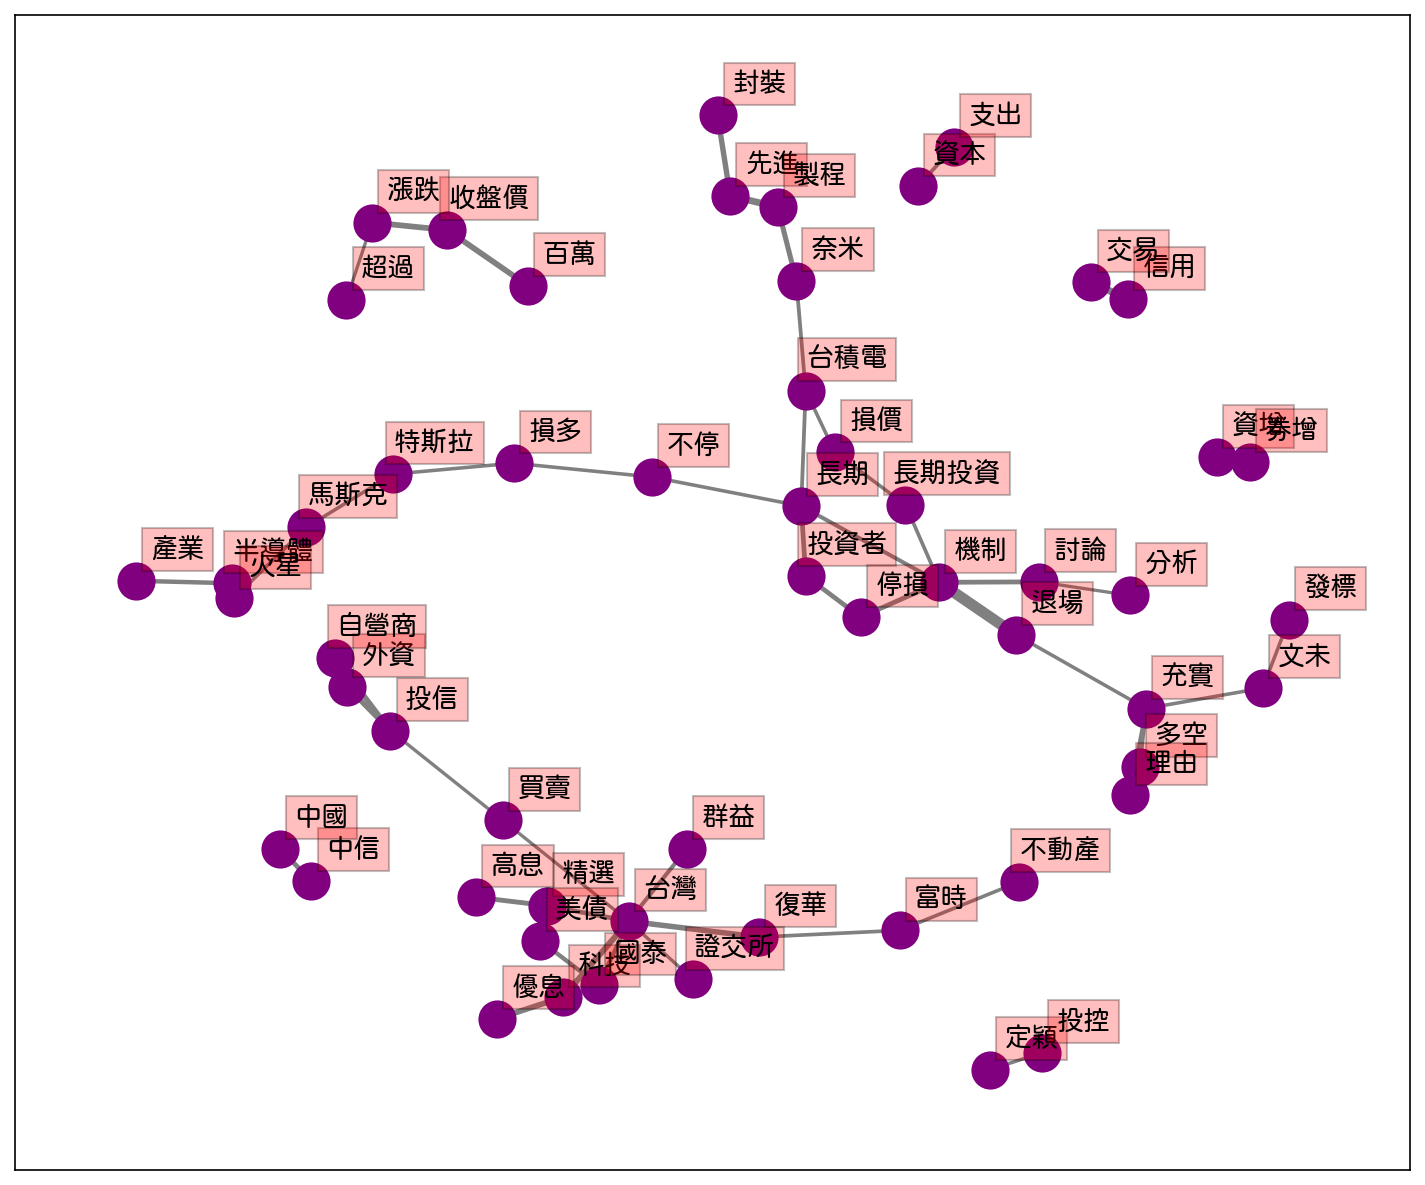

In [26]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramfdist.most_common(50)}

# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率

# 取得edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=1.5)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

## Step 1-6 透過CKIP與SnowNLP產生情緒分數

### Step 1-6-1 建立CKIP模型

In [27]:
ws = WS("/Users/aiden/Downloads/data") 
pos = POS("/Users/aiden/Downloads/data")
ner = NER("/Users/aiden/Downloads/data")

/opt/anaconda3/envs/python38/lib/python3.8/site-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
2024-05-06 03:45:30.633057: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/opt/anaconda3/envs/python38/lib/python3.8/site-packages/ckiptagger/model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
/opt/anaconda3/envs/python38/lib/python3.8/site-packages/ckiptagger/model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This cl

In [28]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    

    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
    # print(len(paragraphs))
    # print(paragraphs)
    
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

In [29]:
# 讀取檔案內容
with open('./dict/TSMC_lexicon.txt', 'r') as f:
    lines = f.readlines()

# 對每一列新增 ", 500"
new_lines = [line.strip() + " 500\n" for line in lines]

# 將結果寫回檔案
with open('./dict/TSMC_lexicon_ckip.txt', 'w') as f:
    f.writelines(new_lines)

In [30]:
# 自定義辭典
with open('./dict/TSMC_lexicon_ckip.txt') as f:
    lines = f.read().splitlines()

userdict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(userdict)
print(dictionary2)

[(2, {'中租': 500.0, '融券': 500.0, '增加': 500.0, '減少': 500.0, '券增': 500.0, '券減': 500.0, '資增': 500.0, '資減': 500.0, '台泥': 500.0, '亞泥': 500.0, '嘉泥': 500.0, '環泥': 500.0, '幸福': 500.0, '信大': 500.0, '東泥': 500.0, '味全': 500.0, '味王': 500.0, '大成': 500.0, '大飲': 500.0, '卜蜂': 500.0, '統一': 500.0, '泰山': 500.0, '福壽': 500.0, '台榮': 500.0, '佳格': 500.0, '聯華': 500.0, '天仁': 500.0, '黑松': 500.0, '興泰': 500.0, '宏亞': 500.0, '安心': 500.0, '德麥': 500.0, '乾杯': 500.0, '台塑': 500.0, '南亞': 500.0, '台聚': 500.0, '華夏': 500.0, '三芳': 500.0, '亞聚': 500.0, '台苯': 500.0, '國喬': 500.0, '聯成': 500.0, '達新': 500.0, '上曜': 500.0, '東陽': 500.0, '大洋': 500.0, '永裕': 500.0, '地球': 500.0, '恆大': 500.0, '台化': 500.0, '台翰': 500.0, '昭輝': 500.0, '八貫': 500.0, '新纖': 500.0, '南染': 500.0, '宏洲': 500.0, '東和': 500.0, '廣豐': 500.0, '嘉裕': 500.0, '東華': 500.0, '新紡': 500.0, '利華': 500.0, '福懋': 500.0, '中福': 500.0, '裕豐': 500.0, '中和': 500.0, '南紡': 500.0, '大東': 500.0, '名軒': 500.0, '立益': 500.0, '力麗': 500.0, '大宇': 500.0, '宏和': 500.0, '力鵬': 500.0, '佳和': 500.0, '年興': 500.0, '宏益': 

In [31]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
    # print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id, word, pos]) 
    # print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
    # print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3], entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    # 遍歷 dataframe 的每筆資料
    for index, row in data_df.iterrows(): # document level    
    # print(f"\ndocument {index}") 

        # 資料清理 ＆ 斷句
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2)
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        # 遍歷該 document 中的每一個句子
        for i, sentence in enumerate(flat_list):
            # print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'], sentence])            
            temp_tokens = get_pos(row['system_id'], word_sentence_list[i], pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'], entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [32]:
df.dropna(subset=['artContent'], inplace=True)
pos_table, entity_table, sentence_table = get_nlp_result(df)

time costing: 1032.6766579151154


### Step 1-6-1 儲存CKIP模型所產生的sentence_table

In [33]:
# 將文章存成csv
pos_table.to_csv("ckipdata/pos_table_buffet.csv", index = False)
entity_table.to_csv("ckipdata/entity_table_buffet.csv", index = False)
sentence_table.to_csv("ckipdata/sentence_table_TSMC.csv", index = False)

### Step 1-6-3 透過SnowNLP產生情緒分數
+ SnowNLP 針對中文設計，可以提取句子的情緒分類
+ 使用文件分類法，套件已預先用文集訓練模型以判斷情緒
+ 情緒值在 0~1之間，代表負面到正面
+ 官方github: https://github.com/isnowfy/snownlp

In [34]:
sentence_table = pd.read_csv("ckipdata/sentence_table_TSMC.csv") #匯入資料
sentiment_date = pd.merge(sentence_table,df[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()
sentiment_date.head(3)

,system_id,sentence,artDate,dataSource
0,1,原文標題,2023-03-31 10:11:59,ptt
1,1,台積電全年營運承壓超預期新單縮手聯發科大砍單,2023-03-31 10:11:59,ptt
2,1,原文連結,2023-03-31 10:11:59,ptt


In [35]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head(3)

,system_id,sentence,artDate,dataSource,sentimentValue
0,1,原文標題,2023-03-31 10:11:59,ptt,0.062369
1,1,台積電全年營運承壓超預期新單縮手聯發科大砍單,2023-03-31 10:11:59,ptt,0.340797
2,1,原文連結,2023-03-31 10:11:59,ptt,0.614853


In [36]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe()

count    1.163930e+05
mean     4.419216e-01
std      2.913975e-01
min      2.220446e-15
25%      1.895647e-01
50%      4.737672e-01
75%      6.570671e-01
max      1.000000e+00
Name: sentimentValue, dtype: float64

<Axes: >

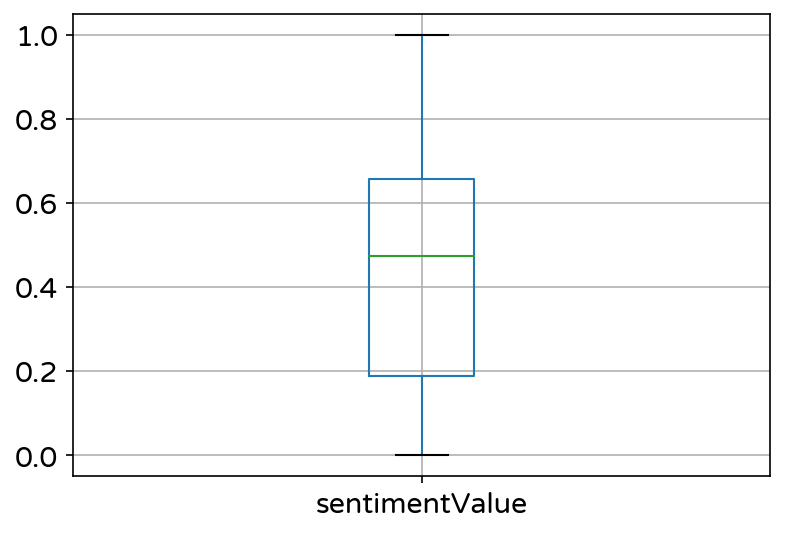

In [37]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

### Step 1-6-4 ByDate確認Stock-TSMC每日情緒

In [38]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('D')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count

,artDate,sentimentValue
0,2023-03-31,0.451674
1,2023-04-01,0.413529
2,2023-04-02,0.369851
3,2023-04-03,0.364607
4,2023-04-04,0.377494
...,...,...
336,2024-03-27,0.402155
337,2024-03-28,0.535679
338,2024-03-29,0.474002
339,2024-03-30,0.312211


/var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/ipykernel_2312/857956447.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


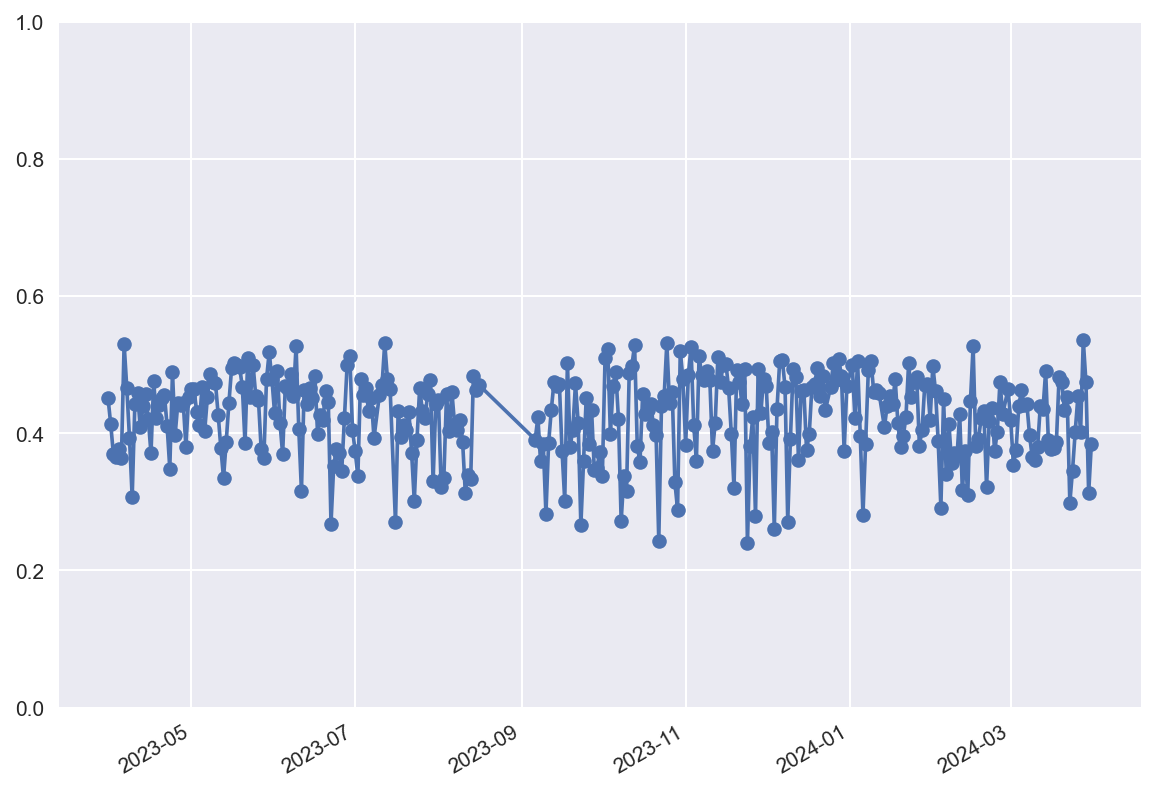

In [39]:
# 平均情緒分數時間趨勢
months = [period.to_timestamp() for period in sentiment_count['artDate']]   # 將 PeriodIndex 中的每個 Period 物件轉換為對應的 datetime 物件
y = sentiment_count['sentimentValue']

plt.style.use('seaborn')

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.ylim(0, 1)

plt.show()

## Step 1-7 從台灣證交所下載股票資訊

In [40]:
TWSE2303 = pd.read_csv('./TWSE/STOCK_DAY_2330_202303.csv', encoding = 'UTF-8', skiprows=1, nrows=23)
TWSE2304 = pd.read_csv('./TWSE/STOCK_DAY_2330_202304.csv', encoding = 'UTF-8', skiprows=1, nrows=17)
TWSE2305 = pd.read_csv('./TWSE/STOCK_DAY_2330_202305.csv', encoding = 'UTF-8', skiprows=1, nrows=22)
TWSE2306 = pd.read_csv('./TWSE/STOCK_DAY_2330_202306.csv', encoding = 'UTF-8', skiprows=1, nrows=20)
TWSE2307 = pd.read_csv('./TWSE/STOCK_DAY_2330_202307.csv', encoding = 'UTF-8', skiprows=1, nrows=21)
TWSE2308 = pd.read_csv('./TWSE/STOCK_DAY_2330_202308.csv', encoding = 'UTF-8', skiprows=1, nrows=22)
TWSE2309 = pd.read_csv('./TWSE/STOCK_DAY_2330_202309.csv', encoding = 'UTF-8', skiprows=1, nrows=20)
TWSE2310 = pd.read_csv('./TWSE/STOCK_DAY_2330_202310.csv', encoding = 'UTF-8', skiprows=1, nrows=20)
TWSE2311 = pd.read_csv('./TWSE/STOCK_DAY_2330_202311.csv', encoding = 'UTF-8', skiprows=1, nrows=21)
TWSE2312 = pd.read_csv('./TWSE/STOCK_DAY_2330_202312.csv', encoding = 'UTF-8', skiprows=1, nrows=21)
TWSE2401 = pd.read_csv('./TWSE/STOCK_DAY_2330_202401.csv', encoding = 'UTF-8', skiprows=1, nrows=22)
TWSE2402 = pd.read_csv('./TWSE/STOCK_DAY_2330_202402.csv', encoding = 'UTF-8', skiprows=1, nrows=13)
TWSE2403 = pd.read_csv('./TWSE/STOCK_DAY_2330_202403.csv', encoding = 'UTF-8', skiprows=1, nrows=21)
TWSE = pd.concat([TWSE2303, TWSE2304, TWSE2305, TWSE2306, TWSE2307, TWSE2308, TWSE2309, TWSE2310, TWSE2311, TWSE2312, TWSE2401, TWSE2402, TWSE2403]).reset_index()
TWSE.head()

,index,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數,Unnamed: 9
0,0,112/03/01,"45,971,058","23,624,972,884",504.0,522.0,504.0,522.0,+11.00,"31,738",NaN
1,1,112/03/02,"18,017,085","9,344,352,321",519.0,520.0,515.0,519.0,-3.00,"14,320",NaN
2,2,112/03/03,"24,117,189","12,510,608,773",524.0,525.0,516.0,516.0,-3.00,"22,160",NaN
3,3,112/03/06,"24,741,125","12,883,854,256",520.0,524.0,517.0,521.0,+5.00,"20,678",NaN
4,4,112/03/07,"27,650,283","14,465,320,023",521.0,526.0,519.0,524.0,+3.00,"20,595",NaN


### Step 1-7-1 民國日期轉成西元

In [41]:
for i in range(len(TWSE)):
    year = int(TWSE.loc[i, '日期'].split('/')[0]) + 1911
    month_day = TWSE.loc[i, '日期'].split('/')[1:]
    new_date = '/'.join([str(year)] + month_day)
    TWSE.loc[i, '日期'] = new_date

In [42]:
TWSE['日期'] = pd.to_datetime(TWSE['日期'], format='%Y/%m/%d')
TWSE['日期'] = TWSE['日期'].dt.to_period('D')
TWSE.head()

,index,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數,Unnamed: 9
0,0,2023-03-01,"45,971,058","23,624,972,884",504.0,522.0,504.0,522.0,+11.00,"31,738",NaN
1,1,2023-03-02,"18,017,085","9,344,352,321",519.0,520.0,515.0,519.0,-3.00,"14,320",NaN
2,2,2023-03-03,"24,117,189","12,510,608,773",524.0,525.0,516.0,516.0,-3.00,"22,160",NaN
3,3,2023-03-06,"24,741,125","12,883,854,256",520.0,524.0,517.0,521.0,+5.00,"20,678",NaN
4,4,2023-03-07,"27,650,283","14,465,320,023",521.0,526.0,519.0,524.0,+3.00,"20,595",NaN


### Step 1-7-2 計算每日股票漲跌%

In [43]:
# 將收盤價轉換為浮點數
TWSE['收盤價'] = TWSE['收盤價'].astype(float)

# 取得前一筆收盤價
TWSE['前一筆收盤價'] = TWSE['收盤價'].shift(1)

# 計算收盤價變動率並以百分比形式顯示，取到小數點第一位
TWSE['股價漲幅'] = ((TWSE['前一筆收盤價'] - TWSE['收盤價']) / TWSE['前一筆收盤價']) * 100
TWSE['股價漲幅'] = TWSE['股價漲幅'].round(2)

# 刪除包含 NaN 值的列
TWSE = TWSE.dropna(subset=['股價漲幅'])

# 刪除不需要的欄位
TWSE = TWSE.drop(columns=['前一筆收盤價'])

# 檢視結果
TWSE.head()

,index,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數,Unnamed: 9,股價漲幅
1,1,2023-03-02,"18,017,085","9,344,352,321",519.0,520.0,515.0,519.0,-3.00,"14,320",NaN,0.57
2,2,2023-03-03,"24,117,189","12,510,608,773",524.0,525.0,516.0,516.0,-3.00,"22,160",NaN,0.58
3,3,2023-03-06,"24,741,125","12,883,854,256",520.0,524.0,517.0,521.0,+5.00,"20,678",NaN,-0.97
4,4,2023-03-07,"27,650,283","14,465,320,023",521.0,526.0,519.0,524.0,+3.00,"20,595",NaN,-0.58
5,5,2023-03-08,"27,077,587","14,091,713,576",521.0,523.0,518.0,521.0,-3.00,"20,504",NaN,0.57


### Step 1-7-3 產生標籤：漲/跌/持平

In [44]:
# 定義條件
conditions = [
    (TWSE['股價漲幅'] == 0), 
    (TWSE['股價漲幅'] > 0) , #& (TWSE['股價漲幅'] < 5),
    #(TWSE['股價漲幅'] >= 5),
    (TWSE['股價漲幅'] < 0), #& (TWSE['股價漲幅'] > -5),
    #(TWSE['股價漲幅'] <= -5)
]

# 定義標籤
labels = ['持平', '漲', '跌']

# 新增欄位並套用條件
TWSE['漲跌狀況'] = np.select(conditions, labels, default='其他')

# 檢視結果
TWSE.head()


,index,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數,Unnamed: 9,股價漲幅,漲跌狀況
1,1,2023-03-02,"18,017,085","9,344,352,321",519.0,520.0,515.0,519.0,-3.00,"14,320",NaN,0.57,漲
2,2,2023-03-03,"24,117,189","12,510,608,773",524.0,525.0,516.0,516.0,-3.00,"22,160",NaN,0.58,漲
3,3,2023-03-06,"24,741,125","12,883,854,256",520.0,524.0,517.0,521.0,+5.00,"20,678",NaN,-0.97,跌
4,4,2023-03-07,"27,650,283","14,465,320,023",521.0,526.0,519.0,524.0,+3.00,"20,595",NaN,-0.58,跌
5,5,2023-03-08,"27,077,587","14,091,713,576",521.0,523.0,518.0,521.0,-3.00,"20,504",NaN,0.57,漲


### Step 1-7-4 設定當日文章會影響"明天"股價漲跌

In [45]:
TWSE= TWSE[["日期","股價漲幅","漲跌狀況"]]
#PPT文章預測1天數的股價
TWSE['pDate'] = (TWSE['日期'] + 1)
TWSE.rename(columns={'日期': 'Date'}, inplace=True)
TWSE.rename(columns={'股價漲幅': '%CHG'}, inplace=True)
TWSE.rename(columns={'漲跌狀況': 'status'}, inplace=True)
TWSE.head()

,Date,%CHG,status,pDate
1,2023-03-02,0.57,漲,2023-03-03
2,2023-03-03,0.58,漲,2023-03-04
3,2023-03-06,-0.97,跌,2023-03-07
4,2023-03-07,-0.58,跌,2023-03-08
5,2023-03-08,0.57,漲,2023-03-09


### Step 1-7-5 將證交所資料與爬蟲資料合併

In [46]:
sentiment_byArticle = sentiment_date.groupby(['system_id'])['sentimentValue'].mean().reset_index()

# 合併兩個資料集
merged_Meta = pd.merge(MetaData, sentiment_byArticle, how='left', left_on='system_id', right_on='system_id')
merged_Meta = pd.merge(merged_Meta, TWSE, how='left', left_on='artDate', right_on='pDate')
merged_Meta.drop(columns=['Date'], inplace=True)
merged_Meta.drop(columns=['pDate'], inplace=True)
merged_Meta = merged_Meta.dropna(subset=['%CHG'])
merged_Meta.rename(columns={'%CHG': 'Tomorrow_%chg'}, inplace=True)
merged_Meta.rename(columns={'status': 'Tomorrow_status'}, inplace=True)
# 檢視合併後的資料集
merged_Meta.head()
#print(f"total docs: {merged_Meta.shape[0]}")

,system_id,artUrl,artTitle,artDate,artContent,sentence,sentimentValue,Tomorrow_%chg,Tomorrow_status
0,1,https://www.ptt.cc/bbs/Stock/M.1680228721.A.45...,[新聞]台積電全年營運承壓超預期 NVIDIA新單縮,2023-03-31,原文標題：\n\n台積電全年營運承壓超預期 NVIDIA新單縮手、聯發科大砍單\n\n原文連...,原文標題台積電全年營運承壓超預期新單縮手聯發科大砍單原文連結發布時間記者署名陳玉娟新竹原文內...,0.263690,-0.94,跌
1,2,https://www.ptt.cc/bbs/Stock/M.1680229357.A.BB...,[標的]智原3035空,2023-03-31,-\n1.發標的文未充實內文，\n多空理由不充實\n者，板規1-1-5或4-4處份\n2.進...,發標的文未充實內文多空理由不充實者板規或處份進退場機制若非長期投資請輸入停損價否則依板規處份...,0.262998,-0.94,跌
2,3,https://www.ptt.cc/bbs/Stock/M.1680232746.A.1B...,[新聞]談美晶片法案補助！劉德音直言：有些限,2023-03-31,原文標題：\n\n談美晶片法案補助！劉德音直言：有些限制無法接受\n\n原文連結：\nhtt...,原文標題談美晶片法案補助劉德音直言有些限制無法接受原文連結發布時間記者署名原文內容美國晶片法...,0.404397,-0.94,跌
3,4,https://www.ptt.cc/bbs/Stock/M.1680235347.A.3A...,[新聞]美補助晶片要看營業祕密,2023-03-31,原文標題：\n\n美補助晶片 要看營業祕密\n\n原文連結：\nhttps://money....,原文標題美補助晶片要看營業祕密原文連結發布時間記者署名劉忠勇黃淑玲記者尹慧中原文內容美國商務...,0.412820,-0.94,跌
4,5,https://www.ptt.cc/bbs/Stock/M.1680235848.A.9C...,[標的]軍工過節多,2023-03-31,1. 標的：軍工類股\n(例 2330.TW 台積電)\n2. 分類：多\n\n3. 分析/...,標的軍工類股例台積電分類多分析正文幾個分析點阿共在演習小英五號要見麥卡錫剛好六號開盤六號阿共...,0.358889,-0.94,跌


In [47]:
TSMC = merged_Meta.copy()

TSMC = TSMC[["system_id", "artDate", "sentence", "sentimentValue", "Tomorrow_%chg", "Tomorrow_status"]]
TSMC["words"] = TSMC.sentence.apply(getToken).map(" ".join)
TSMC.head()

,system_id,artDate,sentence,sentimentValue,Tomorrow_%chg,Tomorrow_status,words
0,1,2023-03-31,原文標題台積電全年營運承壓超預期新單縮手聯發科大砍單原文連結發布時間記者署名陳玉娟新竹原文內...,0.263690,-0.94,跌,台積電 營運 承壓 預期 新單 縮手 聯發科 玉娟 新竹 預估 台積電 第季 營收 將續 下...
1,2,2023-03-31,發標的文未充實內文多空理由不充實者板規或處份進退場機制若非長期投資請輸入停損價否則依板規處份...,0.262998,-0.94,跌,發標 文未 充實 多空 理由 充實 退場 機制 長期投資 損價 台積電 長期 不停 損多 特...
2,3,2023-03-31,原文標題談美晶片法案補助劉德音直言有些限制無法接受原文連結發布時間記者署名原文內容美國晶片法...,0.404397,-0.94,跌,談美 晶片 法案 補助 劉德音 直言 接受 美國 晶片 法案 補助 接受 廠商 申請 台積電...
3,4,2023-03-31,原文標題美補助晶片要看營業祕密原文連結發布時間記者署名劉忠勇黃淑玲記者尹慧中原文內容美國商務...,0.412820,-0.94,跌,補助 晶片 營業 祕密 忠勇 淑玲 尹慧中 美國商務部 公布 晶片 法案 補助 細節 投資 ...
4,5,2023-03-31,標的軍工類股例台積電分類多分析正文幾個分析點阿共在演習小英五號要見麥卡錫剛好六號開盤六號阿共...,0.358889,-0.94,跌,軍工 類股例 台積電 分析 幾個 分析 點阿共 演習 小英 五號 麥卡錫 六號 開盤 六號 ...


In [48]:
TSMC.tail(10)

,system_id,artDate,sentence,sentimentValue,Tomorrow_%chg,Tomorrow_status,words
2746,2751,2024-03-29,標題八大公股銀行買賣超排行來源玩股網網址內文手機介面圖片好讀版以下資訊依張數排列買超賣超排名...,0.542755,1.28,漲,八大 公股 銀行 買賣 股網 手機 介面 資訊 依張數 排列 買超 賣超 排名 股票 數排 ...
2747,2752,2024-03-29,標題年月日信用交易統計來源臺灣證券交易所證券櫃檯買賣中心公司名網站名網址請善用縮網址工具內文...,0.646931,1.28,漲,信用 交易 臺灣 櫃檯 買賣 中心 公司 網站 善用 工具 信用 交易 項目 買進賣出 現金...
2748,2753,2024-03-29,外資排行股票名稱百萬收盤價漲跌緯創台積電廣達群益高息緯穎中興電聯茂雙鴻英業達復華優息資料來源...,0.459004,1.28,漲,外資 百萬 收盤價 漲跌 緯創 台積電 廣達 群益 高息 緯穎 中興電 聯茂 雙鴻 英業達 ...
2749,2754,2024-03-30,標的台塑化分類多空討論心得心得分析正文台塑化一直是大媽長久以來想要買的個股無奈以前一張都要十...,0.180297,-1.30,跌,台塑化 多空 討論 分析 台塑化 大媽 長久以來 想要 個股 無奈 一張 十萬多 下手 趁現...
2750,2755,2024-03-30,謝金河傳產股窗外有藍天台股萬點的投資新思維經濟日報先探投資週刊台股示意圖圖聯合報系資料照片台...,0.342223,-1.30,跌,金河 傳產股 窗外 藍天 台股 萬點 投資 新思維 經濟日報 先探 投資 週刊 台股 示意 ...
2751,2756,2024-03-30,旋風台股月寫奇蹟王淑以台北報導年月日週六上午月台股大漲不僅站上萬點創新高並超越美日股市成為全...,0.282867,-1.30,跌,旋風 台股 奇蹟 王淑以 台北 週六 上午 月台 股大漲 站上 萬點 創新 高並 超越 美日...
2752,2757,2024-03-30,台股站上兩萬點離崩盤不遠達人重點在投資選股年月日台股大盤在台積電的帶動下跳空大漲超過四百點一...,0.231101,-1.30,跌,台股 站上 萬點 崩盤 不遠 達人 重點 投資 選股 台股 大盤 台積電 帶動 跳空 大漲 ...
2753,2758,2024-03-30,下禮拜開始第二季行情因為第三季第四季肯定各公司業績大爆發加上川普參選美國降息全球股市不能不漲...,0.424687,-1.30,跌,下禮拜 第二季 行情 第三季 第四季 肯定 公司業績 爆發 川普 參選 美國 降息 全球股市...
2754,2759,2024-03-30,原文標題台積電年內難有競爭對手能超越專家預估股價能買這些參與原文連結發布時間聯合新聞網雨果記...,0.360495,-1.30,跌,台積電 內難 競爭對手 超越 專家 預估 股價 參與 聯合 新聞網 雨果 聯合 新聞網 雨果...
2755,2760,2024-03-30,減少對中台技術依賴美國考慮和墨西哥合作開發半導體供應鏈科技新報美國國務院週四日表示隨著拜登政...,0.439751,-1.30,跌,減少 中台 技術 依賴 美國 墨西哥 合作開發 半導體供應鏈 科技 新報 美國國務院 週四 ...


In [49]:
print(f"total docs: {TSMC.shape[0]}")

total docs: 2031


In [50]:
print(f"total posts: {len(TSMC['system_id'].unique())}")
print(f"category: \n{TSMC['Tomorrow_status'].value_counts()}")

total posts: 2031
category: 
Tomorrow_status
跌     971
漲     918
持平    142
Name: count, dtype: int64


# Step 2 建立模型
## Step 2-1 將資料以7:3比例切成train set & test set

### 使用bert_ch 計算embedding

In [50]:
# 中文 bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

No sentence-transformers model found with name google-bert/bert-base-chinese. Creating a new one with MEAN pooling.
/opt/anaconda3/envs/python38/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/anaconda3/envs/python38/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


0

In [52]:
# 過濾 nan 的資料
merged_Meta = merged_Meta.dropna(subset=['artTitle'])
merged_Meta = merged_Meta.dropna(subset=['artContent'])
# 移除網址格式
merged_Meta["artContent"] = merged_Meta.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
merged_Meta["artTitle"] = merged_Meta["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
merged_Meta["artContent"] = merged_Meta.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
merged_Meta["artTitle"] = merged_Meta["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)

# 留下 content
merged_Meta["content"] = merged_Meta["artTitle"] + merged_Meta["artContent"]
merged_Meta = merged_Meta[["content", "artUrl", "Tomorrow_status"]]  # 文章內容 文章連結
merged_Meta.head()

,content,artUrl,Tomorrow_status
0,新聞台積電全年營運承壓超預期新單縮原文標題台積電全年營運承壓超預期新單縮手聯發科大砍單原文連...,https://www.ptt.cc/bbs/Stock/M.1680228721.A.45...,跌
1,標的智原空發標的文未充實內文多空理由不充實者板規或處份進退場機制若非長期投資請輸入停損價否則...,https://www.ptt.cc/bbs/Stock/M.1680229357.A.BB...,跌
2,新聞談美晶片法案補助劉德音直言有些限原文標題談美晶片法案補助劉德音直言有些限制無法接受原文連...,https://www.ptt.cc/bbs/Stock/M.1680232746.A.1B...,跌
3,新聞美補助晶片要看營業祕密原文標題美補助晶片要看營業祕密原文連結發布時間記者署名劉忠勇黃淑玲...,https://www.ptt.cc/bbs/Stock/M.1680235347.A.3A...,跌
4,標的軍工過節多標的軍工類股例台積電分類多分析正文幾個分析點阿共在演習小英五號要見麥卡錫剛好六...,https://www.ptt.cc/bbs/Stock/M.1680235848.A.9C...,跌


In [53]:
merged_Meta["embeddings"] = merged_Meta.content.apply(lambda x: bert_ch.encode(x))
merged_Meta.head(3)

,content,artUrl,Tomorrow_status,embeddings
0,新聞台積電全年營運承壓超預期新單縮原文標題台積電全年營運承壓超預期新單縮手聯發科大砍單原文連...,https://www.ptt.cc/bbs/Stock/M.1680228721.A.45...,跌,"[0.38536555, 0.021240776, -0.6129916, 0.256334..."
1,標的智原空發標的文未充實內文多空理由不充實者板規或處份進退場機制若非長期投資請輸入停損價否則...,https://www.ptt.cc/bbs/Stock/M.1680229357.A.BB...,跌,"[0.25396007, -0.022725986, -0.34456924, -0.110..."
2,新聞談美晶片法案補助劉德音直言有些限原文標題談美晶片法案補助劉德音直言有些限制無法接受原文連...,https://www.ptt.cc/bbs/Stock/M.1680232746.A.1B...,跌,"[0.3686449, -0.17465469, -0.6065696, 0.1125472..."


In [54]:
import numpy as np
from ast import literal_eval

In [58]:
TSMC_embedding_data = merged_Meta.copy()
X = TSMC_embedding_data["embeddings"].apply(pd.Series)
y = TSMC_embedding_data["Tomorrow_status"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

           0         1         2         3         4         5         6    \
1634  0.297867 -0.429706 -0.298689 -0.060780 -0.436964 -0.199870  0.028964   
2095  0.492508 -0.163699 -0.302798  0.225326 -0.056897 -0.256824  0.058413   
2520  0.459603  0.146211 -0.282982  0.514468  0.070160 -0.309655  0.200638   
2300  0.450051 -0.337560 -0.393782  0.052159 -0.426711 -0.154509  0.007877   
2673  0.477655 -0.241467 -0.292445  0.047062 -0.109075 -0.137466 -0.091574   

           7         8         9    ...       758       759       760  \
1634 -0.298898 -0.172494 -0.029616  ...  0.493113 -0.161569 -0.177600   
2095 -0.013133 -0.051939 -0.201192  ...  0.127430 -0.102555  0.177440   
2520  0.045624 -0.048138 -0.184036  ...  0.112632 -0.350657  0.121056   
2300 -0.251829 -0.173963 -0.061057  ...  0.448755 -0.137643 -0.003528   
2673 -0.014243 -0.262076 -0.146785  ...  0.203124  0.025062  0.136448   

           761       762       763       764       765       766       767  
1634 -0.036629 

In [59]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
clf

/opt/anaconda3/envs/python38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [60]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)
print(y_pred[:10])

['漲' '漲' '漲' '跌' '跌' '漲' '跌' '跌' '跌' '漲']


In [61]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          持平       0.09      0.03      0.05        32
           漲       0.47      0.44      0.45       284
           跌       0.49      0.56      0.52       294

    accuracy                           0.48       610
   macro avg       0.35      0.34      0.34       610
weighted avg       0.46      0.48      0.47       610



### 這是原本使用DTM+LogisticRegression的結果
![CleanShot 2024-05-06 at 04.30.12.png](<attachment:CleanShot 2024-05-06 at 04.30.12.png>)
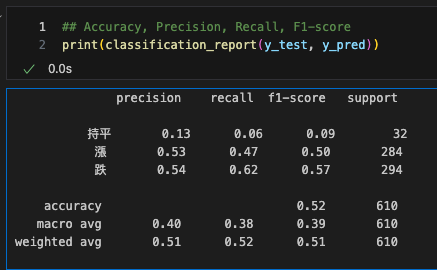

### 結束使用bert_ch 計算embedding

In [62]:
TSMC_data = TSMC
X = TSMC_data[["words", "sentimentValue"]]
y = TSMC_data["Tomorrow_status"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

                                                  words  sentimentValue
1634  投信 買賣 台灣 證交所 成分股 調整 買超 聯電 統一 康舒 永豐金 仁寶 欣興 富邦金 ...        0.532418
2095  成看 英特爾 亞利桑那 建奈 米廠 英特爾 致力於 先進 製程 缺乏 穩定 量產 技術 聯電...        0.407711
2520  喜歡 立法院 一堆 委員 私下 歐印 藍藍 立委 有人 飽飽 股市 萬點 執政黨 努力 給予...        0.184660
2300  上市 外資 買賣 買超 買超 復華 台灣 科技 優息 陽明 長榮 國泰 智能 電動車 中信金...        0.548931
2673  元大台灣 價值 高息 台積電 討論 分析 新聞 透露 部份 成分股 正確 神達 亞翔 合勤控...        0.523226
1634    跌
2095    跌
2520    跌
2300    漲
2673    漲
Name: Tomorrow_status, dtype: object


## Step 2-2 確認比例是否正確

In [63]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{TSMC_data['Tomorrow_status'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
Tomorrow_status
跌     47.808961
漲     45.199409
持平     6.991630
Name: proportion, dtype: float64

train percentage :
Tomorrow_status
跌     47.642505
漲     44.616467
持平     7.741027
Name: proportion, dtype: float64

test percentage :
Tomorrow_status
跌     48.196721
漲     46.557377
持平     5.245902
Name: proportion, dtype: float64


## Step 2-3 使用CountVectorizer進行分類預測

In [64]:
#嘗試過50, 100, 200, 500, 1000 效果皆差不多，可能可以判斷文章的雜訊過多。
features=100
vectorizer = CountVectorizer(max_features=features)
vec_train = vectorizer.fit_transform(X_train["words"])
print(vectorizer.get_feature_names_out()[:10])

['三星' '上漲' '中信' '中國' '中鋼' '交易' '今日' '企業' '信用' '個股']


In [65]:
# fit 完後，可以用 `vocabulary_` 看到詞的 feature index
print(vectorizer.vocabulary_)
#vectorizer.vocabulary_

{'投信': 43, '買賣': 83, '台灣': 22, '買超': 84, '聯電': 70, '長榮航': 95, '長榮': 94, '聯發科': 69, '賣超': 88, '廣達': 35, '緯創': 65, '台積電': 23, '技嘉': 41, '英特爾': 78, '先進': 14, '製程': 81, '技術': 42, '合作': 25, '美國': 68, '奈米': 31, '三星': 0, '股市': 73, '未來': 52, '外資': 29, '復華': 37, '科技': 64, '國泰': 26, '元大台灣': 13, '高息': 98, '中信': 2, '中國': 3, '股息': 74, '鴻海': 99, '半導體': 20, '成長': 39, '國泰永續高股息': 27, '討論': 82, '分析': 17, '英業達': 77, '中鋼': 4, '漲跌': 57, '資料': 86, '股價': 71, '營收': 58, '產能': 62, '台股': 24, '今日': 6, '指出': 47, '影響': 36, '表現': 80, '企業': 7, '公司': 16, '預期': 97, '持續': 45, '億元': 11, '增加': 28, '持股': 46, '機會': 54, '個股': 9, '法人': 55, '全球': 15, '蘋果': 79, '需求': 96, '相關': 63, '指數': 48, '股東': 75, '投資': 44, '停損': 10, '股利': 72, '去年': 21, '超過': 89, '晶片': 51, '封裝': 33, '獲利': 59, '上漲': 1, '股票': 76, '退場': 91, '機制': 53, '長期': 93, '客戶': 32, '生產': 60, '市值': 34, '大盤': 30, '交易': 5, '包括': 19, '成交量': 38, '美元': 67, '漲停': 56, '資金': 87, '產業': 61, '輝達': 90, '信用': 8, '金額': 92, '資增': 85, '券增': 18, '美債': 66, '手機': 40, '明年': 50, '億美元': 12, '日本'

In [66]:
vec_test = vectorizer.transform(X_test["words"])
print(vec_train.shape)
print(vec_test.shape)

(1421, 100)
(610, 100)


In [67]:
# 將情感值特徵轉換為疏密矩陣
vec_train_sentiment = X_train["sentimentValue"].values.reshape(-1, 1)
vec_test_sentiment = X_test["sentimentValue"].values.reshape(-1, 1)

# 將文字特徵和情感值特徵合併成一個疏密矩陣
import scipy.sparse as sp
import numpy as np

vec_train = sp.hstack((vec_train, vec_train_sentiment))
vec_test = sp.hstack((vec_test, vec_test_sentiment))

### Step 2-3-1 建立LogisticRegression分類器

In [68]:
# 建立分類器模型
clf = LogisticRegression()
clf.fit(vec_train, y_train)
clf

/opt/anaconda3/envs/python38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [69]:
clf.classes_

array(['持平', '漲', '跌'], dtype=object)

In [70]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
print(y_pred[:10])

['跌' '漲' '漲' '持平' '跌' '漲' '跌' '漲' '跌' '跌']


In [71]:
print(y_pred_proba.shape)
y_pred_proba[0,:]

(610, 3)


array([0.00057704, 0.47189323, 0.52752973])

### Step 2-3-2 計算F1-score

In [72]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          持平       0.13      0.06      0.09        32
           漲       0.53      0.47      0.50       284
           跌       0.54      0.62      0.57       294

    accuracy                           0.52       610
   macro avg       0.40      0.38      0.39       610
weighted avg       0.51      0.52      0.51       610



### Step 2-3-3 混淆矩陣

In [73]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[  2,  13,  17],
       [  9, 134, 141],
       [  4, 108, 182]])

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, '持平'), Text(0, 1.5, '漲'), Text(0, 2.5, '跌')])

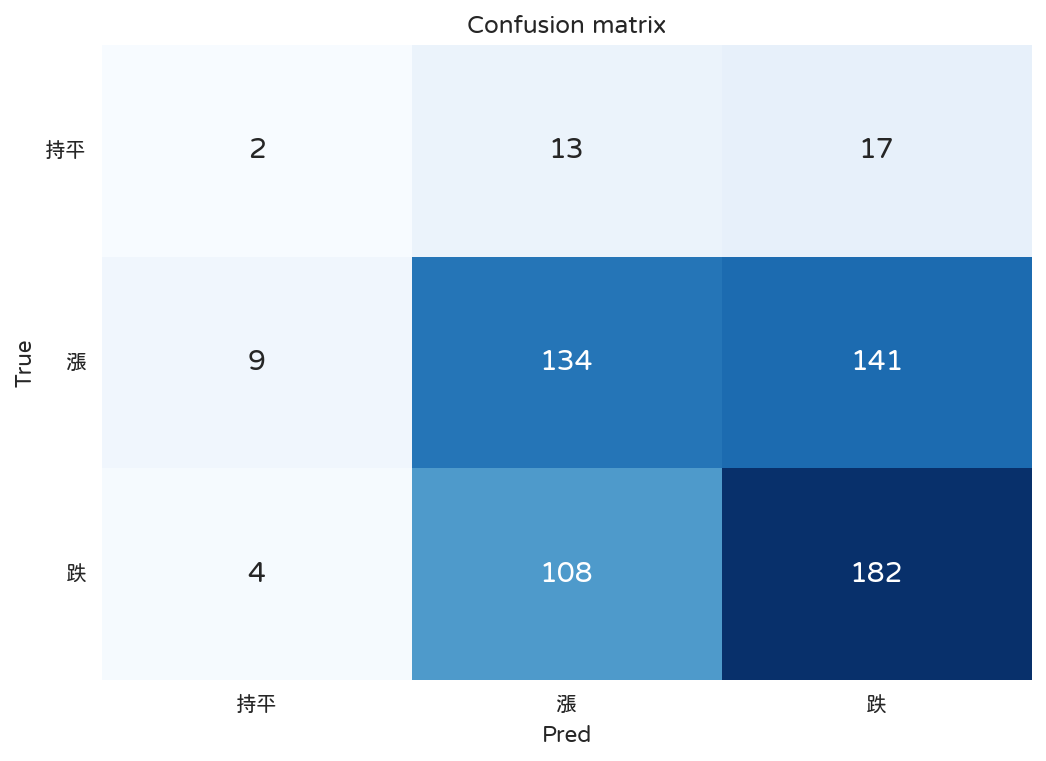

In [74]:
## Plot confusion matrix
plt.rcParams['font.sans-serif'] = ['jf-openhuninn-2.0'] #金萱粉圓體2.0

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

## Step 2-4 使用TfidfVectorizer進行分類預測

In [75]:
vectorizer = TfidfVectorizer(max_features=features)
vec_train = vectorizer.fit_transform(X_train["words"])
vec_test = vectorizer.transform(X_test["words"])

# 將情感值特徵轉換為疏密矩陣
vec_train_sentiment = X_train["sentimentValue"].values.reshape(-1, 1)
vec_test_sentiment = X_test["sentimentValue"].values.reshape(-1, 1)

# 將文字特徵和情感值特徵合併成一個疏密矩陣
import scipy.sparse as sp
import numpy as np

vec_train = sp.hstack((vec_train, vec_train_sentiment))
vec_test = sp.hstack((vec_test, vec_test_sentiment))

### Step 2-4-1 使用LogisticRegression分類器
### Step 2-4-2 計算F1-Score

In [76]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          持平       0.00      0.00      0.00        32
           漲       0.50      0.51      0.51       284
           跌       0.52      0.57      0.54       294

    accuracy                           0.51       610
   macro avg       0.34      0.36      0.35       610
weighted avg       0.48      0.51      0.50       610



/opt/anaconda3/envs/python38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/python38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/python38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Step 2-5 不同模型 + CV 進行分類預測
+ Logistic Regression
+ decision Tree
+ SVM
+ Random forest

### Step 2-5-1 CV = 5

In [77]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title= str(clf) + "Confusion matrix",
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

### Step 2-5-2 TfidfVectorizer

### Step 2-5-3 建立各個模型的混淆矩陣

now training: clf_logistic


/opt/anaconda3/envs/python38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/python38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/python38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda

              precision    recall  f1-score   support

          持平       0.00      0.00      0.00       110
           漲       0.46      0.48      0.47       634
           跌       0.48      0.53      0.50       677

    accuracy                           0.47      1421
   macro avg       0.31      0.34      0.32      1421
weighted avg       0.43      0.47      0.45      1421

now training: clf_dtree
              precision    recall  f1-score   support

          持平       0.07      0.07      0.07       110
           漲       0.46      0.45      0.45       634
           跌       0.49      0.51      0.50       677

    accuracy                           0.45      1421
   macro avg       0.34      0.34      0.34      1421
weighted avg       0.45      0.45      0.45      1421

now training: clf_svm


/opt/anaconda3/envs/python38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/python38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/python38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda

              precision    recall  f1-score   support

          持平       0.00      0.00      0.00       110
           漲       0.47      0.48      0.48       634
           跌       0.49      0.55      0.52       677

    accuracy                           0.48      1421
   macro avg       0.32      0.34      0.33      1421
weighted avg       0.44      0.48      0.46      1421

now training: clf_rf
              precision    recall  f1-score   support

          持平       0.00      0.00      0.00       110
           漲       0.48      0.49      0.49       634
           跌       0.50      0.56      0.53       677

    accuracy                           0.49      1421
   macro avg       0.32      0.35      0.34      1421
weighted avg       0.45      0.49      0.47      1421



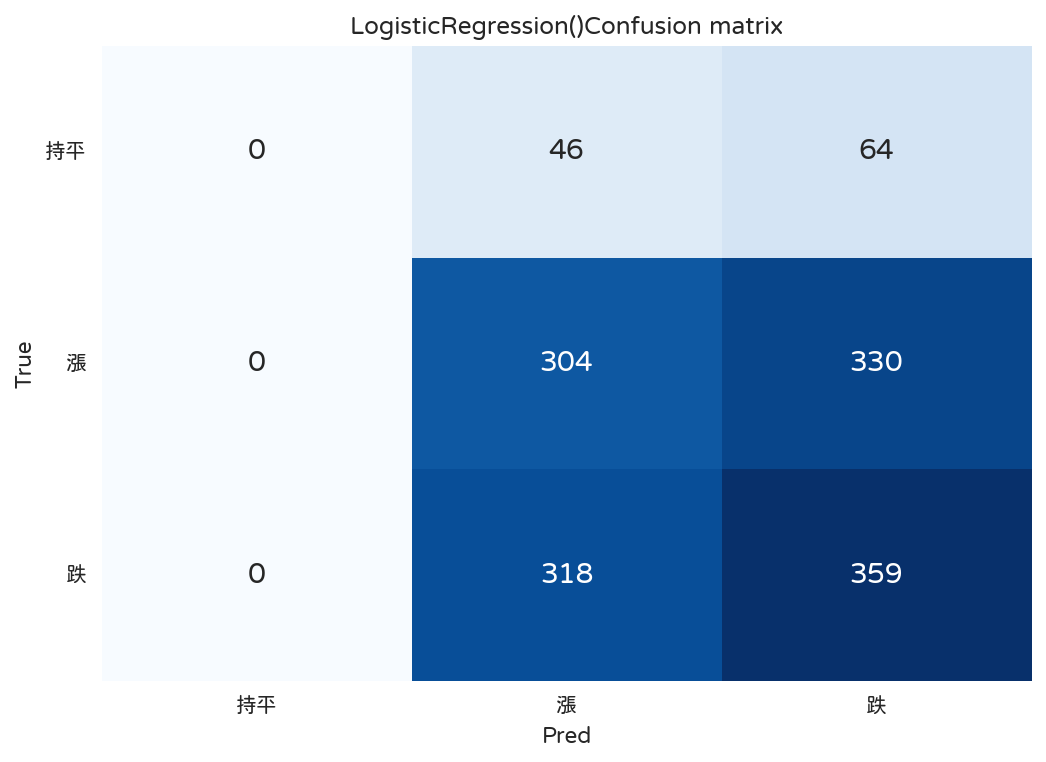

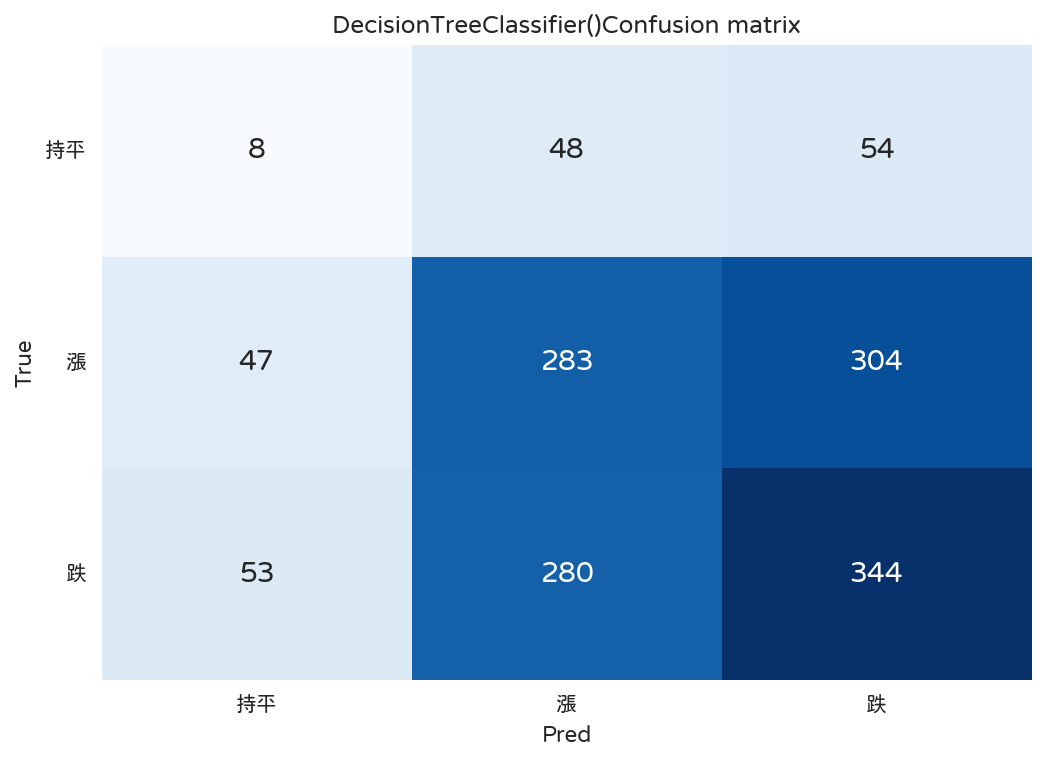

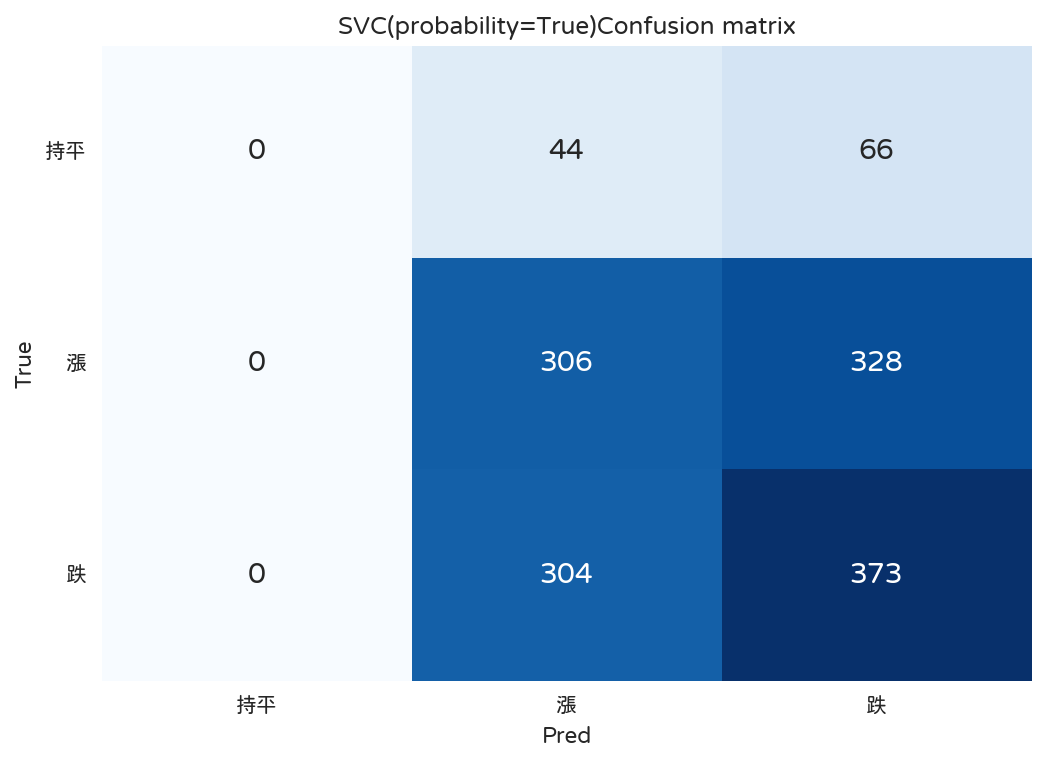

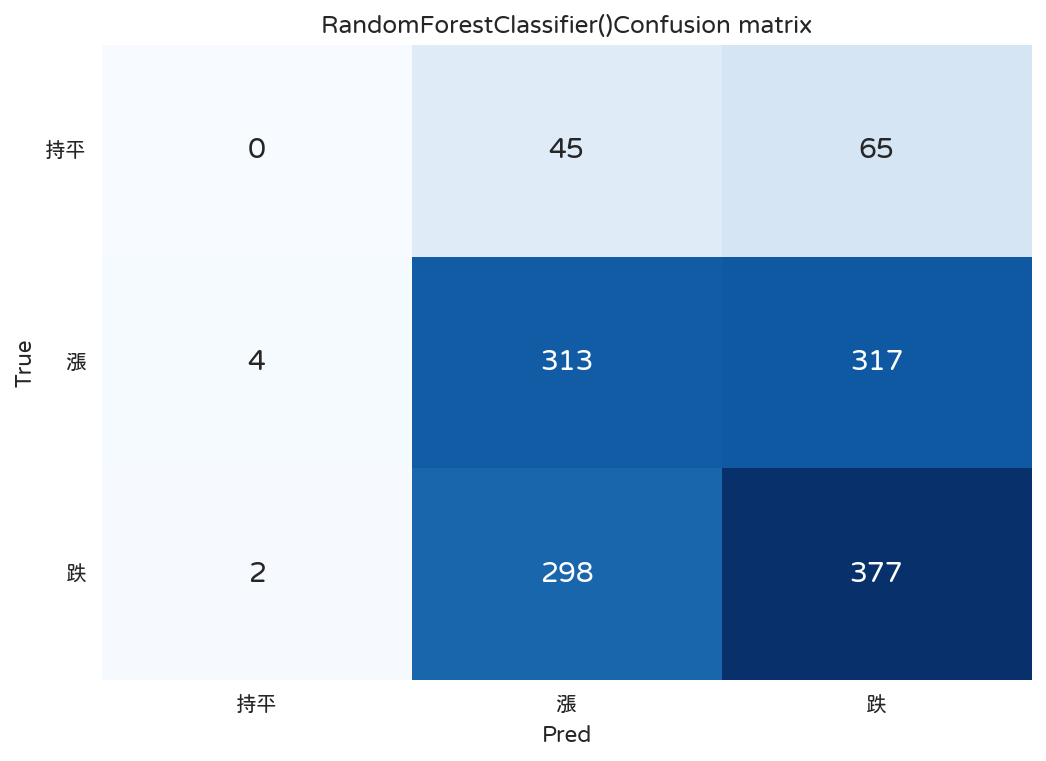

In [78]:
# 準備訓練資料
X = TSMC_data["words"]
y = TSMC_data["Tomorrow_status"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True) # 要使用SVM的predict_proba的話，必須在叫出SVC的時候就將probability設為True
model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
#vectorizer = CountVectorizer(max_features=features)
vectorizer = TfidfVectorizer(max_features=features)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)

### Step 2-5-4 尋找最佳的模型(Best F1-Score)

In [79]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_rf
{'accuracy': 0.48557353976073186,
 'macro avg': {'f1-score': 0.33678031857082186,
               'precision': 0.32461344623327654,
               'recall': 0.35018646313373,
               'support': 1421.0},
 'weighted avg': {'f1-score': 0.46666724866338677,
                  'precision': 0.4495236741781152,
                  'recall': 0.48557353976073186,
                  'support': 1421.0},
 '持平': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 110.0},
 '漲': {'f1-score': 0.48527131782945737,
       'precision': 0.4771341463414634,
       'recall': 0.49369085173501576,
       'support': 634.0},
 '跌': {'f1-score': 0.5250696378830083,
       'precision': 0.49670619235836627,
       'recall': 0.5568685376661743,
       'support': 677.0}}


In [80]:
y_pred = model_set['clf_logistic'].predict(vectorizer.transform(X_test).toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          持平       0.00      0.00      0.00        32
           漲       0.51      0.52      0.52       284
           跌       0.53      0.57      0.55       294

    accuracy                           0.52       610
   macro avg       0.35      0.37      0.36       610
weighted avg       0.49      0.52      0.51       610



/opt/anaconda3/envs/python38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/python38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/python38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Step 2-5-5 產生影響股票漲跌的前10大影響力字詞

In [81]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("odds ratio", size=14)

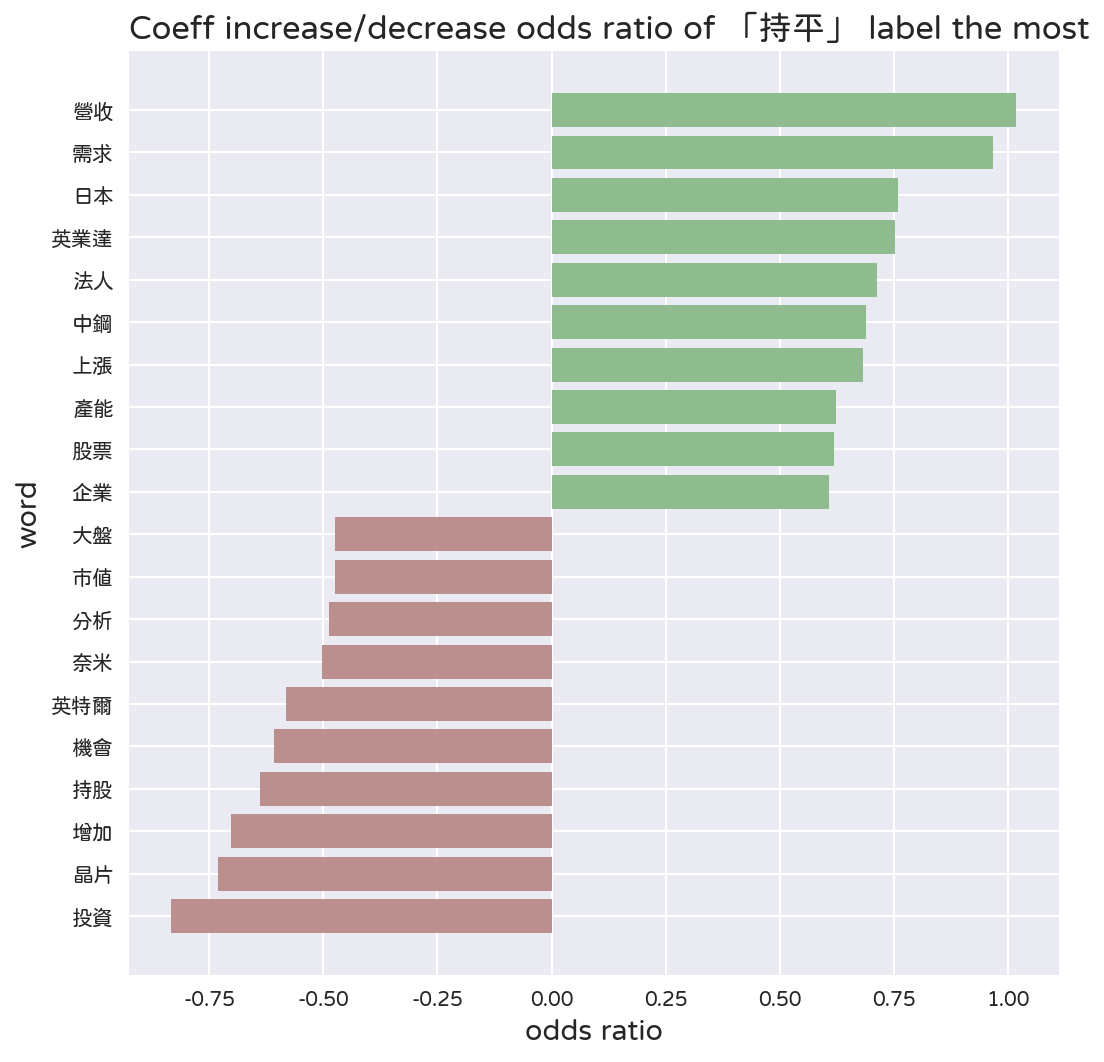

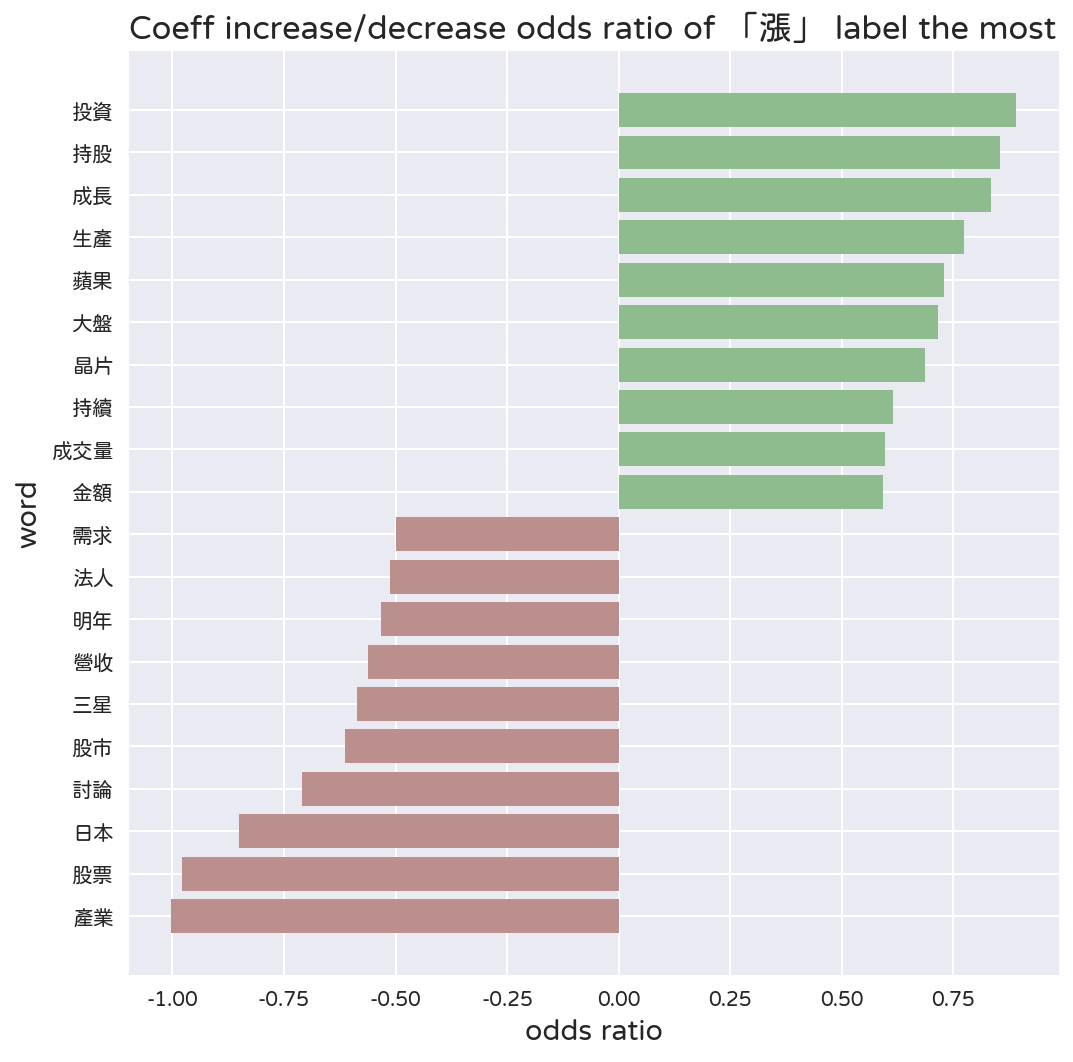

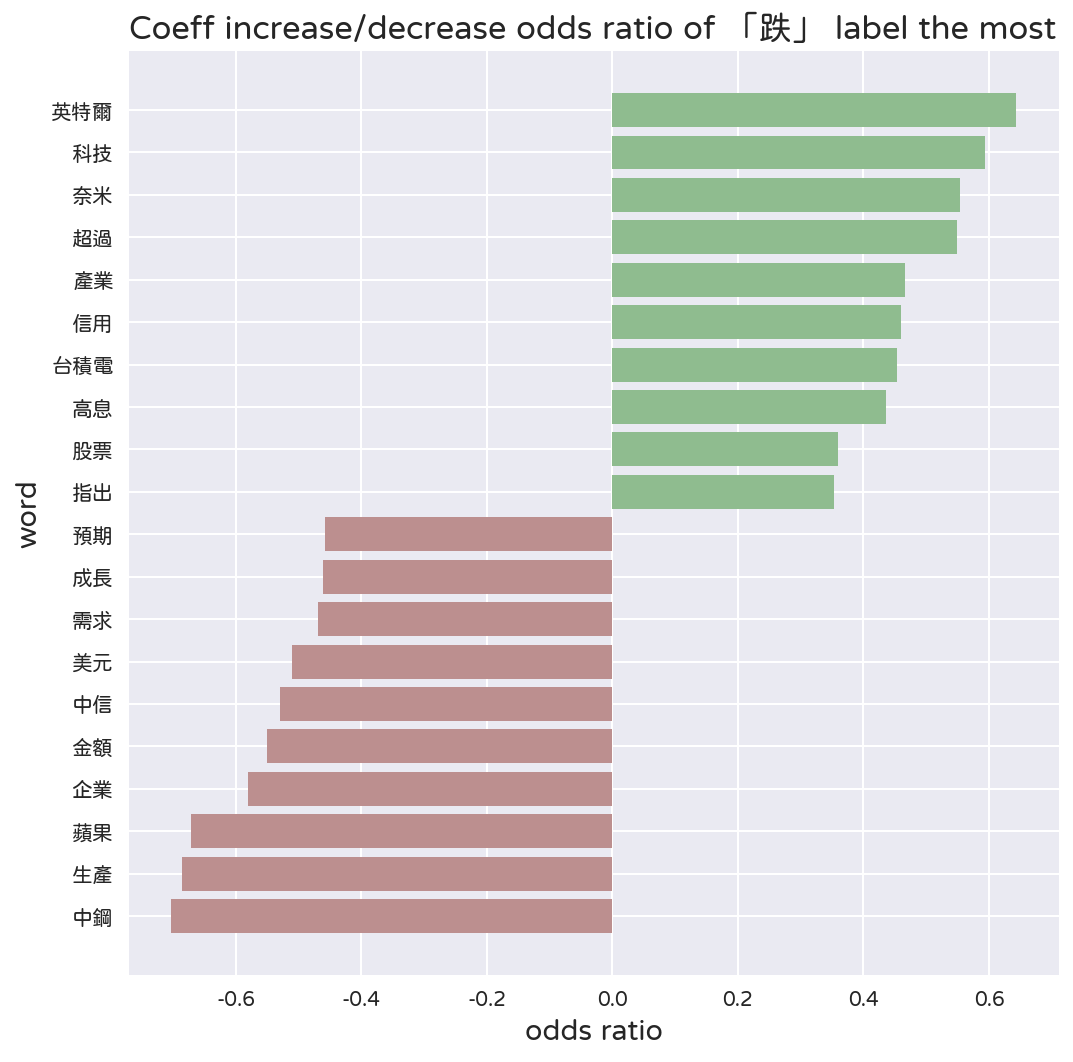

In [82]:
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names_out(), top_n=10)

## Step 2-6 透過文章分析，預測明日漲/跌
+ 資料來源：PTT - 股票版
+ 資料時間範圍：2024/03/31
+ 搜尋關鍵字：台積電
+ 排除關鍵字：
+ 文章總數：6篇

In [83]:
ct = pd.read_csv("./Raw_data/PTT_STOCK_TSMC_240331.csv")
ct.dropna(inplace=True)
ct

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Stock/M.1711840847.A.5D...,[標的]6167久正多,2024-03-31 07:20:45,i815432,Stock,-\n1.發標的文未充實內文，\n多空理由不充實\n者，板規1-1-5或4-4處份\n2.進...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""addy7533967""...",101.9.128.69,2024-04-01 02:25:34,ptt
1,2,https://www.ptt.cc/bbs/Stock/M.1711850809.A.67...,Re:[請益]一次買vs分批買vs等股災才買,2024-03-31 10:06:47,martylin,Stock,但是你乎略了人性\n你全丟下去，它崩了-20%，你頂得住嗎\n長期會往上也許沒錯\n但中間你...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""WenliYang"", ...",220.136.148.56,2024-04-01 02:25:34,ptt
2,3,https://www.ptt.cc/bbs/Stock/M.1711863576.A.1A...,Re:[請益]為什麼這波韓國股市沒有跟著創新高,2024-03-31 13:39:34,huabandd,Stock,並沒有，台灣這一波沒有倒下，就是因為台積電\n\n沒有台積電，AI根本沒有我們的事\n\n沒...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""koushimei"", ...",101.136.78.6,2024-04-01 02:25:51,ptt
3,4,https://www.ptt.cc/bbs/Stock/M.1711873656.A.E4...,[標的]鴻海短空2317,2024-03-31 16:27:34,TroyeSivan,Stock,標的：鴻海 2317\n(例 2330.TW 台積電)\n分類：空\n分析/正文：\n大家好...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""sandwich1028...",180.217.15.61,2024-04-01 02:25:51,ptt
4,5,https://www.ptt.cc/bbs/Stock/M.1711877155.A.4F...,Re:[新聞]比英特爾晚5年？傳台積電2030才用最新EUV,2024-03-31 17:25:50,rosemary0401,Stock,查了一下版上好像沒有相關的後續新聞，\n\nIntel在本月初開箱了這個High-NA EU...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""peter080808""...",113.39.122.17,2024-04-01 02:26:00,ptt
5,6,https://www.ptt.cc/bbs/Stock/M.1711890821.A.5B...,[新聞]護國神山再擴廠？傳台積電將在高雄增2座,2024-03-31 21:13:39,boards,Stock,護國神山再擴廠？傳台積電將在高雄增2座 A14廠 市府回應了\n\n2024-03-31 1...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""guk"", ""cmtCo...",49.216.172.151,2024-04-01 02:26:00,ptt


In [84]:
ct['sentence'] = ct['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
ct['sentence'] = ct['sentence'].apply(lambda x: re.sub('[口]', '', x))
ct = ct[["system_id", "sentence"]]
ct["words"] = ct.sentence.apply(getToken).map(" ".join)
ct.head()

/var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/ipykernel_2312/2338076956.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ct["words"] = ct.sentence.apply(getToken).map(" ".join)


,system_id,sentence,words
0,1,發標的文未充實內文多空理由不充實者板規或處份進退場機制若非長期投資請輸入停損價否則依板規處份...,發標 文未 充實 多空 理由 充實 退場 機制 長期投資 損價 台積電 長期 不停 損多 特...
1,2,但是你乎略了人性你全丟下去它崩了你頂得住嗎長期會往上也許沒錯但中間你會因為虧損過大而賣出這個...,你乎 人性 丟下去 頂得住 長期 會往 也許 沒錯 你會 虧損 過大而 賣出 當初 台積電 ...
2,3,並沒有台灣這一波沒有倒下就是因為台積電沒有台積電根本沒有我們的事沒有台積電三星早就接單到手軟...,台灣 這一波 倒下 台積電 台積電 台積電 三星 早就 接單 手軟 台灣 中國 合作 密不可...
3,4,標的鴻海例台積電分類空分析正文大家好我是鴻海博士上週我準確預言了鴻海賣出點位我連高點都預測到...,鴻海 台積電 分析 鴻海 博士 上週 準確 預言 鴻海 賣出 點位 我連 高點 預測 未來 ...
4,5,查了一下版上好像沒有相關的後續新聞在本月初開箱了這個有報導指出需要三架波音分批運送這台大型機...,版上 相關 後續 新聞 月初 開箱 指出 三架 波音 分批 運送 這台 大型 機器 貨櫃 箱...


In [85]:
X = ct['words']
y_pred = model_set[best_model_name].predict(vectorizer.transform(X).toarray())
ct['pred'] = y_pred
ct

/var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/ipykernel_2312/683476296.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ct['pred'] = y_pred


,system_id,sentence,words,pred
0,1,發標的文未充實內文多空理由不充實者板規或處份進退場機制若非長期投資請輸入停損價否則依板規處份...,發標 文未 充實 多空 理由 充實 退場 機制 長期投資 損價 台積電 長期 不停 損多 特...,漲
1,2,但是你乎略了人性你全丟下去它崩了你頂得住嗎長期會往上也許沒錯但中間你會因為虧損過大而賣出這個...,你乎 人性 丟下去 頂得住 長期 會往 也許 沒錯 你會 虧損 過大而 賣出 當初 台積電 ...,漲
2,3,並沒有台灣這一波沒有倒下就是因為台積電沒有台積電根本沒有我們的事沒有台積電三星早就接單到手軟...,台灣 這一波 倒下 台積電 台積電 台積電 三星 早就 接單 手軟 台灣 中國 合作 密不可...,漲
3,4,標的鴻海例台積電分類空分析正文大家好我是鴻海博士上週我準確預言了鴻海賣出點位我連高點都預測到...,鴻海 台積電 分析 鴻海 博士 上週 準確 預言 鴻海 賣出 點位 我連 高點 預測 未來 ...,跌
4,5,查了一下版上好像沒有相關的後續新聞在本月初開箱了這個有報導指出需要三架波音分批運送這台大型機...,版上 相關 後續 新聞 月初 開箱 指出 三架 波音 分批 運送 這台 大型 機器 貨櫃 箱...,跌
5,6,護國神山再擴廠傳台積電將在高雄增座廠市府回應了聯合報記者蔡世偉高雄即時報導業界傳聞台積電正評...,護國 神山 擴廠 台積電 將在 高雄 增座 市府 回應 聯合報 蔡世偉 高雄 即時 業界 台...,跌


### Step 2-6-1 貌似猜中了
![jupyter](./CleanShot.png)